# **Cluster Analysis**

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Example time transformations:
Hour 0:00 -> sin = 0.000, cos = 1.000
Hour 6:00 -> sin = 1.000, cos = 0.000
Hour 12:00 -> sin = 0.000, cos = -1.000
Hour 18:00 -> sin = -1.000, cos = -0.000
Hour 23:00 -> sin = -0.259, cos = 0.966
Cluster Characteristics:
                kWhDelivered  charging_duration  idle_time  kWh_per_hour  \
Cluster_Cyclic                                                             
0                       4.51               1.96       1.37          2.46   
1                      13.14               2.39       1.56          5.66   
2                      13.73               5.24       2.65          2.76   
3                       6.50               2.29       6.54          2.93   

                time_sin  time_cos  
Cluster_Cyclic                      
0                  -0.77      0.19  
1                  -0.72      0.13  
2                  -0.56     -0.72  
3                  -0.55     -0.73  
Cluster 1 Time Features:
Average minutes into day: 1117.77
Average ho

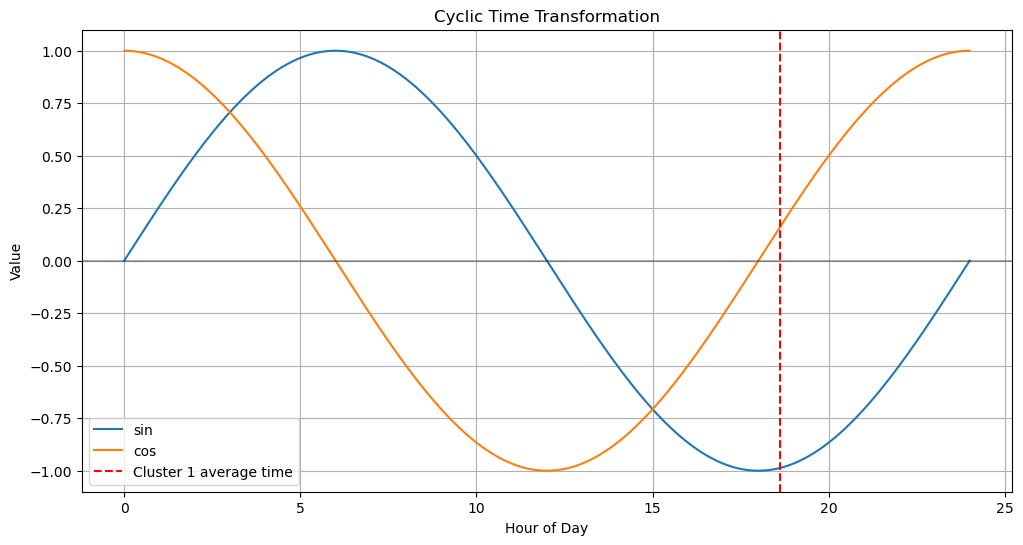

Cluster Characteristics:
                kWhDelivered  charging_duration  idle_time  kWh_per_hour  \
Cluster_Cyclic                                                             
0                       4.51               1.96       1.37          2.46   
1                      13.14               2.39       1.56          5.66   
2                      13.73               5.24       2.65          2.76   
3                       6.50               2.29       6.54          2.93   

                time_sin  time_cos  
Cluster_Cyclic                      
0                  -0.77      0.19  
1                  -0.72      0.13  
2                  -0.56     -0.72  
3                  -0.55     -0.73  
Cluster 1 Time Features:
Average minutes into day: 1117.77
Average hour of day: 18.63
Time sin: -0.72
Time cos: 0.13


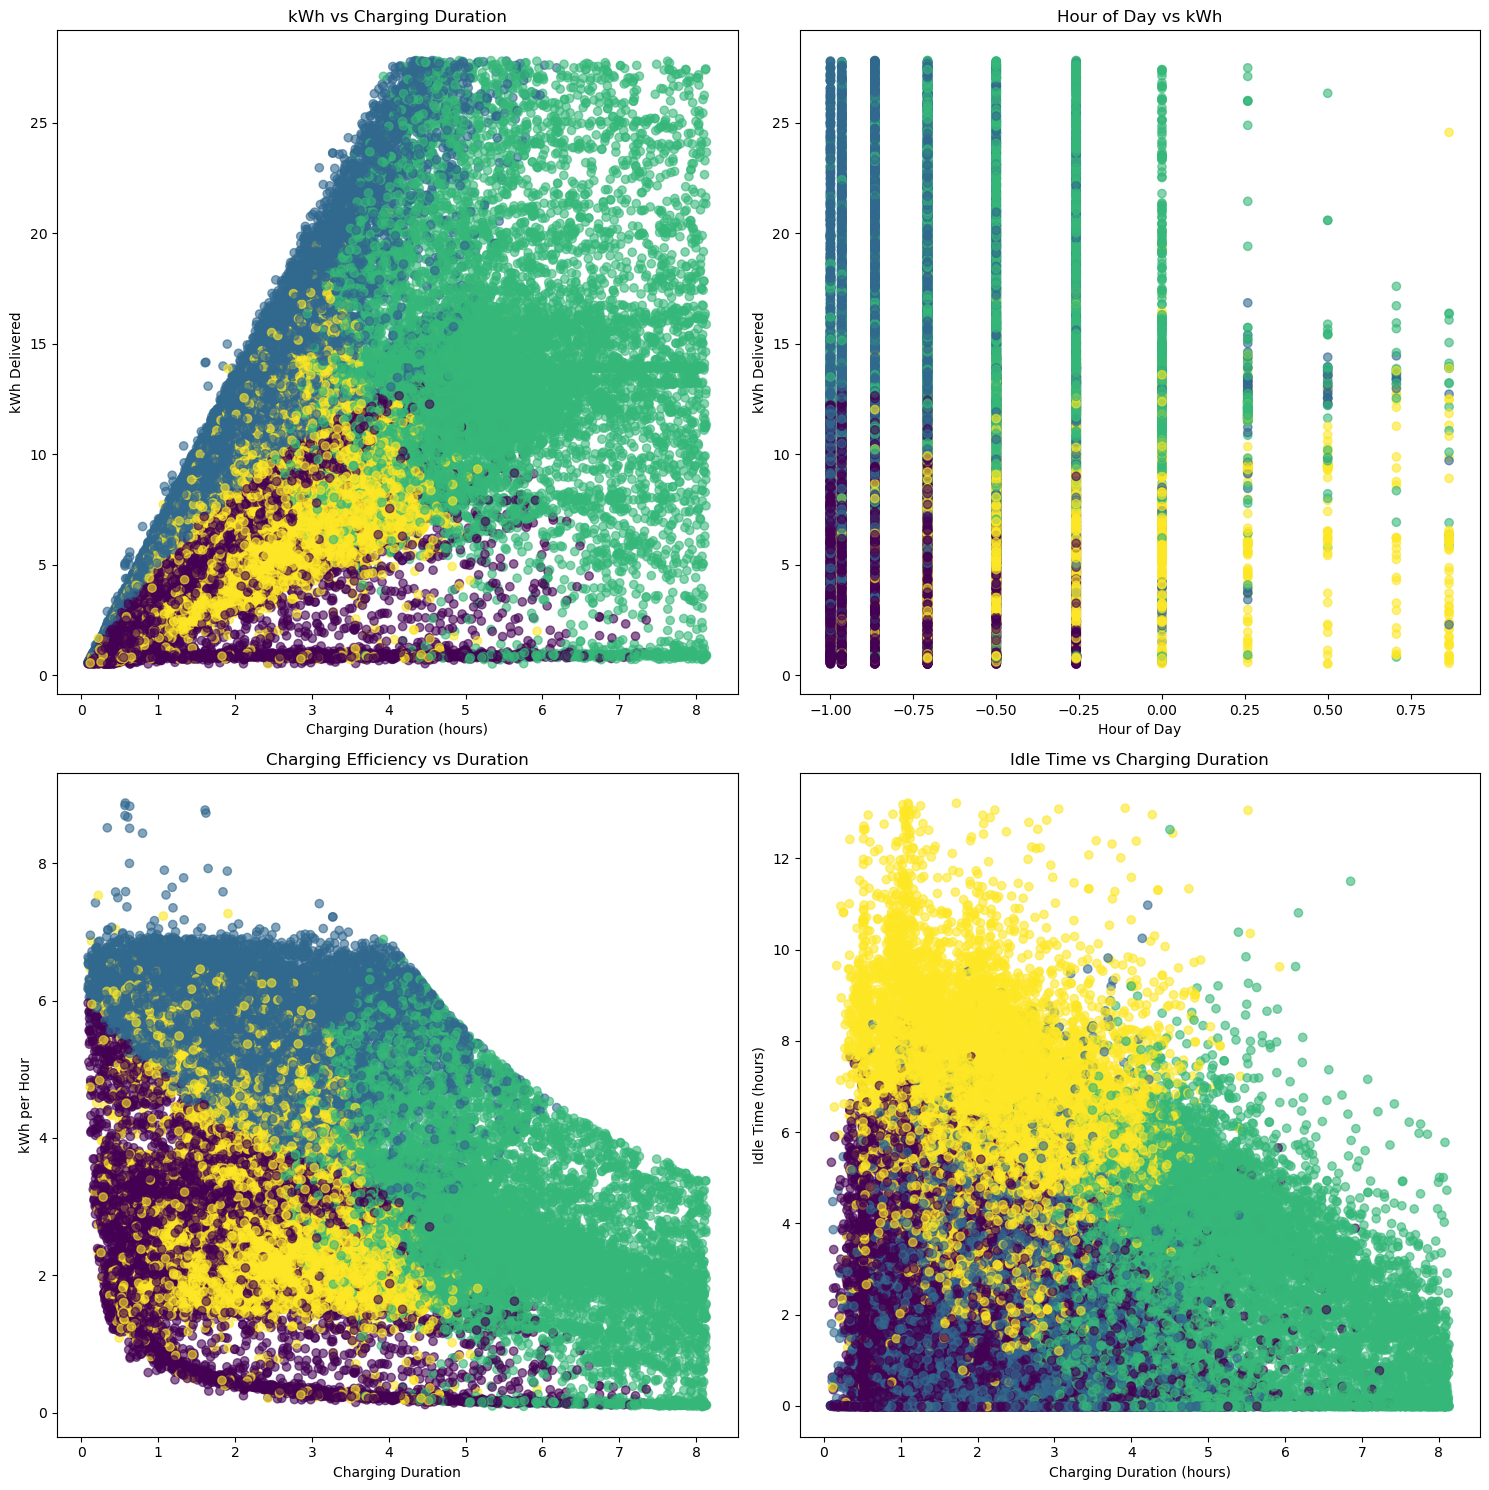

Cluster Characteristics:
                kWhDelivered  charging_duration  idle_time  kWh_per_hour  \
Cluster_Cyclic                                                             
0                       4.51               1.96       1.37          2.46   
1                      13.14               2.39       1.56          5.66   
2                      13.73               5.24       2.65          2.76   
3                       6.50               2.29       6.54          2.93   

                hour_of_day  
Cluster_Cyclic               
0                     18.91  
1                     18.63  
2                     14.55  
3                     14.46  
Number of sessions per cluster:
Cluster_Cyclic
0    12472
1    10515
2    11661
3    12528
Name: count, dtype: int64
Charging Efficiency by Cluster (kWh per total session hour):
Cluster_Cyclic
0    1.687
1    4.140
2    1.881
3    0.811
Name: efficiency, dtype: float64


In [110]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('resources/charging_sessions.csv')

# Convert time columns to datetime
time_columns = ['connectionTime', 'disconnectTime', 'doneChargingTime']
for col in time_columns:
    df[col] = pd.to_datetime(df[col])

# Extract features
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['total_session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['idle_time'] = (df['disconnectTime'] - df['doneChargingTime']).dt.total_seconds() / 3600
df['hour_of_day'] = df['connectionTime'].dt.hour
df['kWh_per_hour'] = df['kWhDelivered'] / df['charging_duration']

# Clean the data
columns_to_clean = ['kWhDelivered', 'charging_duration', 'idle_time', 'kWh_per_hour', 'hour_of_day']
X_clean = remove_outliers_iqr(df, columns_to_clean)

# Convert hour_of_day to minutes
X_clean['minutes_into_day'] = X_clean['hour_of_day'] * 60

# Create cyclic time features
X_clean['time_sin'] = np.sin(2 * np.pi * X_clean['minutes_into_day'] / (24 * 60))
X_clean['time_cos'] = np.cos(2 * np.pi * X_clean['minutes_into_day'] / (24 * 60))

# Let's look at some example times to understand the transformation
example_hours = [0, 6, 12, 18, 23]
example_minutes = [h * 60 for h in example_hours]
example_sin = [np.sin(2 * np.pi * m / (24 * 60)) for m in example_minutes]
example_cos = [np.cos(2 * np.pi * m / (24 * 60)) for m in example_minutes]

print("Example time transformations:")
for h, s, c in zip(example_hours, example_sin, example_cos):
    print(f"Hour {h}:00 -> sin = {s:.3f}, cos = {c:.3f}")

# Features for clustering
features_cyclic = ['kWhDelivered', 'charging_duration', 'idle_time', 'kWh_per_hour', 'time_sin', 'time_cos']

# Scale the features
scaler = StandardScaler()
X_scaled_cyclic = scaler.fit_transform(X_clean[features_cyclic])

# Perform clustering
kmeans_cyclic = KMeans(n_clusters=4, random_state=42)
clusters_cyclic = kmeans_cyclic.fit_predict(X_scaled_cyclic)

# Add cluster labels
X_clean['Cluster_Cyclic'] = clusters_cyclic

# Show cluster characteristics
print("\
Cluster Characteristics:")
cluster_stats = X_clean.groupby('Cluster_Cyclic')[features_cyclic].mean().round(2)
print(cluster_stats)

# Let's specifically look at cluster 1's time features
cluster_1 = X_clean[X_clean['Cluster_Cyclic'] == 1]
print("\
Cluster 1 Time Features:")
print(f"Average minutes into day: {cluster_1['minutes_into_day'].mean():.2f}")
print(f"Average hour of day: {cluster_1['minutes_into_day'].mean() / 60:.2f}")
print(f"Time sin: {cluster_1['time_sin'].mean():.2f}")
print(f"Time cos: {cluster_1['time_cos'].mean():.2f}")

# Create a visualization to understand the cyclic time transformation
minutes = np.linspace(0, 24*60, 1000)
sin_vals = np.sin(2 * np.pi * minutes / (24 * 60))
cos_vals = np.cos(2 * np.pi * minutes / (24 * 60))

plt.figure(figsize=(12, 6))
plt.plot(minutes/60, sin_vals, label='sin')
plt.plot(minutes/60, cos_vals, label='cos')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=cluster_1['minutes_into_day'].mean()/60, color='r', linestyle='--', 
            label='Cluster 1 average time')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.title('Cyclic Time Transformation')
plt.legend()
plt.grid(True)
plt.show()

# Remove outliers using the IQR method
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

# Clean the data
columns_to_clean = ['kWhDelivered', 'charging_duration', 'idle_time', 'kWh_per_hour', 'hour_of_day']
X_clean = remove_outliers_iqr(df, columns_to_clean)

# Convert hour_of_day to minutes
X_clean['minutes_into_day'] = X_clean['hour_of_day'] * 60

# Create cyclic time features
X_clean['time_sin'] = np.sin(2 * np.pi * X_clean['minutes_into_day'] / (24 * 60))
X_clean['time_cos'] = np.cos(2 * np.pi * X_clean['minutes_into_day'] / (24 * 60))

# Features for clustering
features_cyclic = ['kWhDelivered', 'charging_duration', 'idle_time', 'kWh_per_hour', 'time_sin', 'time_cos']

# Scale the features
scaler = StandardScaler()
X_scaled_cyclic = scaler.fit_transform(X_clean[features_cyclic])

# Perform clustering
kmeans_cyclic = KMeans(n_clusters=4, random_state=42)
clusters_cyclic = kmeans_cyclic.fit_predict(X_scaled_cyclic)

# Add cluster labels
X_clean['Cluster_Cyclic'] = clusters_cyclic

# Show cluster characteristics
print("\
Cluster Characteristics:")
cluster_stats = X_clean.groupby('Cluster_Cyclic')[features_cyclic].mean().round(2)
print(cluster_stats)

# Specifically look at cluster 1's time features
cluster_1 = X_clean[X_clean['Cluster_Cyclic'] == 1]
print("\
Cluster 1 Time Features:")
print(f"Average minutes into day: {cluster_1['minutes_into_day'].mean():.2f}")
print(f"Average hour of day: {cluster_1['minutes_into_day'].mean() / 60:.2f}")
print(f"Time sin: {cluster_1['time_sin'].mean():.2f}")
print(f"Time cos: {cluster_1['time_cos'].mean():.2f}")

# Create visualization grid
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot 1: kWh vs charging duration
scatter1 = axes[0,0].scatter(X_clean['charging_duration'], X_clean['kWhDelivered'],
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Charging Duration (hours)')
axes[0,0].set_ylabel('kWh Delivered')
axes[0,0].set_title('kWh vs Charging Duration')

# Plot 2: Hour of day vs kWh
scatter2 = axes[0,1].scatter(X_clean['time_sin'],X_clean['kWhDelivered'],
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('kWh Delivered')
axes[0,1].set_title('Hour of Day vs kWh')

# Plot 3: Charging efficiency
scatter3 = axes[1,0].scatter(X_clean['charging_duration'], X_clean['kWh_per_hour'],
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[1,0].set_xlabel('Charging Duration')
axes[1,0].set_ylabel('kWh per Hour')
axes[1,0].set_title('Charging Efficiency vs Duration')

# Plot 4: Idle time analysis
scatter4 = axes[1,1].scatter(X_clean['charging_duration'], X_clean['idle_time'],
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[1,1].set_xlabel('Charging Duration (hours)')
axes[1,1].set_ylabel('Idle Time (hours)')
axes[1,1].set_title('Idle Time vs Charging Duration')

plt.tight_layout()
plt.show()

# Calculate and print cluster statistics
print("\
Cluster Characteristics:")
print(X_clean.groupby('Cluster_Cyclic')[features].mean().round(2))

# Print size of each cluster
print("\
Number of sessions per cluster:")
print(X_clean['Cluster_Cyclic'].value_counts().sort_index())

# Calculate additional metrics for interpretation
X_clean['efficiency'] = X_clean['kWhDelivered'] / (X_clean['charging_duration'] + X_clean['idle_time'])
print("\
Charging Efficiency by Cluster (kWh per total session hour):")
print(X_clean.groupby('Cluster_Cyclic')['efficiency'].mean().round(3))

Original dataset size: 62360
Dataset size after removing outliers: 56782


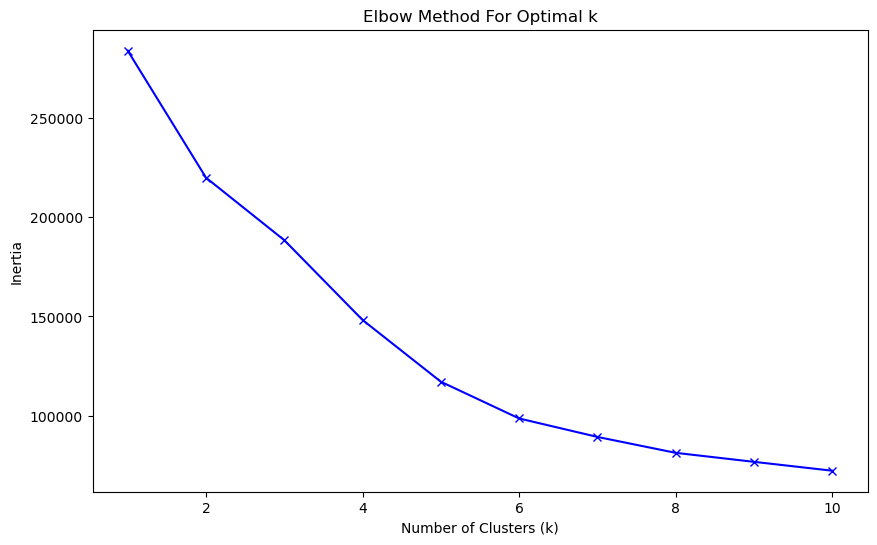

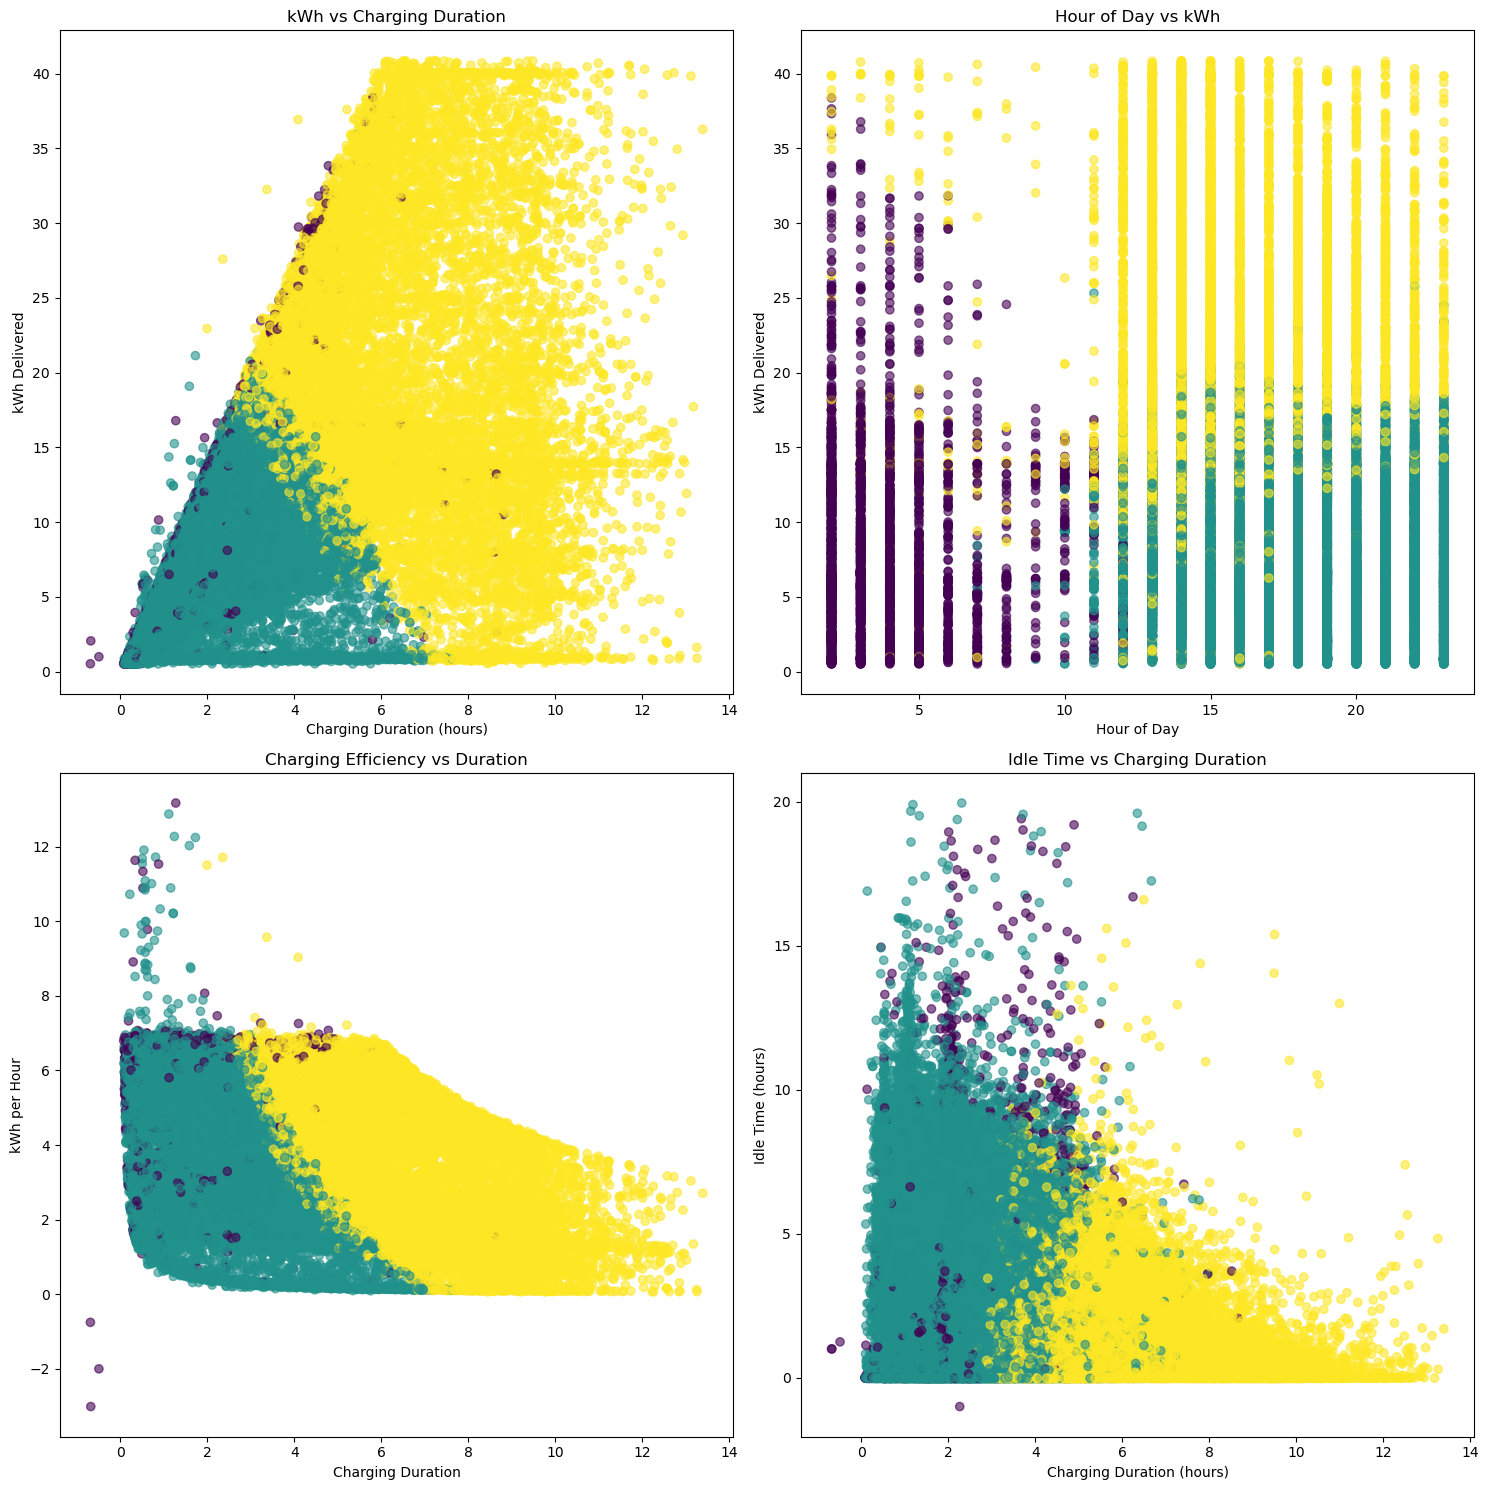

Cluster Characteristics:
         kWhDelivered  charging_duration  idle_time  kWh_per_hour  hour_of_day
Cluster                                                                       
0                8.28               1.84       2.03          4.59         3.89
1                7.10               2.29       3.47          3.34        16.96
2               19.48               6.25       1.71          3.48        15.18
Number of sessions per cluster:
Cluster
0     3618
1    36386
2    16778
Name: count, dtype: int64
Charging Efficiency by Cluster (kWh per total session hour):
Cluster
0    3.486
1    1.855
2    2.760
Name: efficiency, dtype: float64


In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Read and prepare the data
df = pd.read_csv('resources/charging_sessions.csv')

# Convert time columns to datetime
time_columns = ['connectionTime', 'disconnectTime', 'doneChargingTime']
for col in time_columns:
    df[col] = pd.to_datetime(df[col])

# Extract features
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['total_session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['idle_time'] = (df['disconnectTime'] - df['doneChargingTime']).dt.total_seconds() / 3600
df['hour_of_day'] = df['connectionTime'].dt.hour
df['kWh_per_hour'] = df['kWhDelivered'] / df['charging_duration']

# Add these to features for clustering
features = ['kWhDelivered', 'charging_duration', 'idle_time', 'kWh_per_hour', 'hour_of_day']
X = df[features].copy()

# Clean data - remove infinities and NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Remove outliers using IQR method for each feature
def remove_outliers(df, columns, n_std=3):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - n_std * IQR
        upper_bound = Q3 + n_std * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Remove outliers
X_clean = remove_outliers(X, features)

print(f"Original dataset size: {len(X)}")
print(f"Dataset size after removing outliers: {len(X_clean)}")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean[features])

# Try K-means with different numbers of clusters
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on elbow curve, let's use k=4
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters back to the cleaned dataframe
X_clean['Cluster'] = clusters

# Create visualization grid
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot 1: kWh vs charging duration
scatter1 = axes[0,0].scatter(X_clean['charging_duration'], X_clean['kWhDelivered'],
                           c=X_clean['Cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Charging Duration (hours)')
axes[0,0].set_ylabel('kWh Delivered')
axes[0,0].set_title('kWh vs Charging Duration')

# Plot 2: Hour of day vs kWh
scatter2 = axes[0,1].scatter(X_clean['hour_of_day'],X_clean['kWhDelivered'],
                           c=X_clean['Cluster'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('kWh Delivered')
axes[0,1].set_title('Hour of Day vs kWh')

# Plot 3: Charging efficiency
scatter3 = axes[1,0].scatter(X_clean['charging_duration'], X_clean['kWh_per_hour'],
                           c=X_clean['Cluster'], cmap='viridis', alpha=0.6)
axes[1,0].set_xlabel('Charging Duration')
axes[1,0].set_ylabel('kWh per Hour')
axes[1,0].set_title('Charging Efficiency vs Duration')

# Plot 4: Idle time analysis
scatter4 = axes[1,1].scatter(X_clean['charging_duration'], X_clean['idle_time'],
                           c=X_clean['Cluster'], cmap='viridis', alpha=0.6)
axes[1,1].set_xlabel('Charging Duration (hours)')
axes[1,1].set_ylabel('Idle Time (hours)')
axes[1,1].set_title('Idle Time vs Charging Duration')

plt.tight_layout()
plt.show()

# Calculate and print cluster statistics
print("\
Cluster Characteristics:")
print(X_clean.groupby('Cluster')[features].mean().round(2))

# Print size of each cluster
print("\
Number of sessions per cluster:")
print(X_clean['Cluster'].value_counts().sort_index())

# Calculate additional metrics for interpretation
X_clean['efficiency'] = X_clean['kWhDelivered'] / (X_clean['charging_duration'] + X_clean['idle_time'])
print("\
Charging Efficiency by Cluster (kWh per total session hour):")
print(X_clean.groupby('Cluster')['efficiency'].mean().round(3))

In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Read and prepare the data
df = pd.read_csv('resources/charging_sessions.csv')

# Convert time columns to datetime
time_columns = ['connectionTime', 'disconnectTime', 'doneChargingTime']
for col in time_columns:
    df[col] = pd.to_datetime(df[col])

# Extract features
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['total_session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['idle_time'] = (df['disconnectTime'] - df['doneChargingTime']).dt.total_seconds() / 3600
df['minutes_into_day'] = df['connectionTime'].dt.hour
df['kWh_per_hour'] = df['kWhDelivered'] / df['charging_duration']

# Transform 'minutes_into_day' into sine and cosine components to account for cyclic nature
X_clean['time_sin'] = np.sin(2 * np.pi * X_clean['minutes_into_day'] / (24 * 60))
X_clean['time_cos'] = np.cos(2 * np.pi * X_clean['minutes_into_day'] / (24 * 60))

# Update features for clustering
features_cyclic = ['kWhDelivered', 'charging_duration', 'idle_time', 'kWh_per_hour', 'time_sin', 'time_cos']

# Scale the updated features
X_scaled_cyclic = scaler.fit_transform(X_clean[features_cyclic])

# Re-run K-means clustering with the cyclic time features
kmeans_cyclic = KMeans(n_clusters=4, random_state=42)
clusters_cyclic = kmeans_cyclic.fit_predict(X_scaled_cyclic)

# Add cyclic clusters back to the dataframe
X_clean['Cluster_Cyclic'] = clusters_cyclic

# Create visualization grid for cyclic clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot 1: kWh vs charging duration
scatter1 = axes[0,0].scatter(X_clean['kWhDelivered'], X_clean['charging_duration'], 
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('kWh Delivered')
axes[0,0].set_ylabel('Charging Duration (hours)')
axes[0,0].set_title('kWh vs Charging Duration (Cyclic)')

# Plot 2: Time (sin) vs kWh
scatter2 = axes[0,1].scatter(X_clean['time_sin'], X_clean['kWhDelivered'], 
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Time (sin)')
axes[0,1].set_ylabel('kWh Delivered')
axes[0,1].set_title('Time (sin) vs kWh (Cyclic)')

# Plot 3: Charging efficiency
scatter3 = axes[1,0].scatter(X_clean['kWh_per_hour'], X_clean['charging_duration'], 
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[1,0].set_xlabel('kWh per Hour')
axes[1,0].set_ylabel('Charging Duration')
axes[1,0].set_title('Charging Efficiency vs Duration (Cyclic)')

# Plot 4: Idle time analysis
scatter4 = axes[1,1].scatter(X_clean['idle_time'], X_clean['charging_duration'], 
                           c=X_clean['Cluster_Cyclic'], cmap='viridis', alpha=0.6)
axes[1,1].set_xlabel('Idle Time (hours)')
axes[1,1].set_ylabel('Charging Duration (hours)')
axes[1,1].set_title('Idle Time vs Charging Duration (Cyclic)')

plt.tight_layout()
plt.show()

# Calculate and print cyclic cluster statistics
print("\
Cyclic Cluster Characteristics:")
print(X_clean.groupby('Cluster_Cyclic')[features_cyclic].mean().round(2))

# Print size of each cyclic cluster
print("\
Number of sessions per cyclic cluster:")
print(X_clean['Cluster_Cyclic'].value_counts().sort_index())

# Calculate additional metrics for interpretation
X_clean['efficiency_cyclic'] = X_clean['kWhDelivered'] / (X_clean['charging_duration'] + X_clean['idle_time'])
print("\
Cyclic Charging Efficiency by Cluster (kWh per total session hour):")
print(X_clean.groupby('Cluster_Cyclic')['efficiency_cyclic'].mean().round(3))

KeyError: 'minutes_into_day'

In [82]:
df[df['charging_duration'] < 0].count()

Unnamed: 0                27
id                        27
connectionTime            27
disconnectTime            27
doneChargingTime          27
kWhDelivered              27
sessionID                 27
siteID                    27
spaceID                   27
stationID                 27
timezone                  27
userID                     6
userInputs                 6
charging_duration         27
total_session_duration    27
idle_time                 27
hour_of_day               27
kWh_per_hour              27
dtype: int64

In [61]:
try:
    df = pd.read_csv('resources/charging_sessions_cleaned.csv')
    print("Successfully imported charging_sessions.csv")
except FileNotFoundError:
    print("Error: charging_sessions.csv not found.")

Successfully imported charging_sessions.csv


In [64]:
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
df['modifiedAt'] = pd.to_datetime(df['modifiedAt'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
df['requestedDeparture'] = pd.to_datetime(df['requestedDeparture'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
df['connectionDuration'] = pd.to_timedelta(df['connectionDuration'])
df.dtypes

id                                                 object
connectionTime        datetime64[ns, America/Los_Angeles]
disconnectTime        datetime64[ns, America/Los_Angeles]
doneChargingTime      datetime64[ns, America/Los_Angeles]
kWhDelivered                                      float64
sessionID                                          object
siteID                                              int64
spaceID                                            object
stationID                                          object
userID                                            float64
kWhRequested                                      float64
milesRequested                                    float64
modifiedAt            datetime64[ns, America/Los_Angeles]
WhPerMile                                         float64
minutesAvailable                                  float64
requestedDeparture    datetime64[ns, America/Los_Angeles]
connectionDuration                        timedelta64[ns]
chargingDurati

In [65]:
#df = df[['connectionTime', 'kWhRequested']]
df['chargingDuration'] = df['chargingDuration'].dt.
df

AttributeError: Can only use .dt accessor with datetimelike values

In [67]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled_df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
df_scaled_df.head()

k_max = 100
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(df_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)


print("Done")

TypeError: float() argument must be a string or a real number, not 'Timestamp'

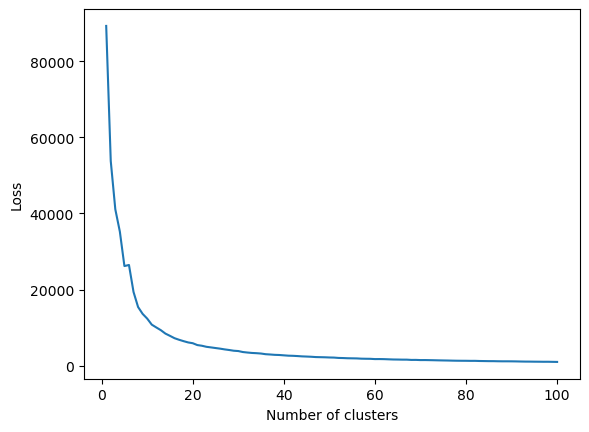

In [61]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

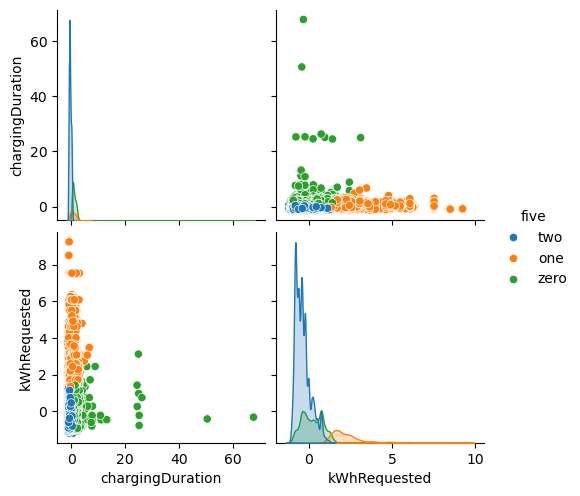

In [62]:
numbers = ["zero", "one", "two"]
asdf_scaled_df = df_scaled_df
three_means = KMeans(n_clusters=3, n_init='auto')
three_means.fit(df_scaled)
three_means.predict(df_scaled)
asdf_scaled_df["five"] = three_means.predict(df_scaled)
asdf_scaled_df["five"] = asdf_scaled_df["five"].apply(lambda x: numbers[x])
sns.pairplot(data=asdf_scaled_df, hue="five")
plt.show()